<a href="https://colab.research.google.com/github/jimin-fundamental/Tamtam-AI/blob/main/tamtam_function1_re_ipynb%EC%9D%98_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D_%EC%B6%94%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autogluon  # 라이브러리 설치 (Colab에서 한 번 실행 필요)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. 

### 1️⃣ 구글 드라이브 마운트 & 데이터 불러오기

In [ ]:
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

# 구글 드라이브 인증 및 마운트
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Google Spreadsheet 불러오기 (스프레드시트 ID 입력 필요)
spreadsheet_url = "https://docs.google.com/spreadsheets/d/12Sg5o--_CymcUwCosa4jK9BRDooNUD5D1Dg4UwbqSi8/edit?gid=2062207367#gid=2062207367"
sheet = gc.open_by_url(spreadsheet_url).sheet1

# 데이터를 DataFrame으로 변환
data = sheet.get_all_records()
df = pd.DataFrame(data)

# ✅ 데이터 확인
print("---------1차------------")
print(df.head())
print(df.columns)


---------1차------------
    timestamp category  target holiday     day merchant mission_topic
0  2024-01-01       교통   11140    TRUE  Monday    카카오택시           택시비
1  2024-01-01       쇼핑  102030    TRUE  Monday      무신사            의류
2  2024-01-01       식비   34550    TRUE  Monday       본죽             죽
3  2024-01-01       쇼핑   83090    TRUE  Monday     에이랜드          악세사리
4  2024-01-01    온라인쇼핑    9360    TRUE  Monday     11번가            가전
Index(['timestamp', 'category', 'target', 'holiday', 'day', 'merchant',
       'mission_topic'],
      dtype='object')


In [ ]:
# TimeSeriesDataFrame 변환 시 컬럼을 명확히 지정
df = TimeSeriesDataFrame.from_data_frame(
    df,  # rename이 적용된 df 사용
    id_column="category"  # 기존 category → item_id로 변경
    # time_column="timestamp"
)

# ✅ MultiIndex → 일반 컬럼 변환
df_reset = df.reset_index()

# 특정 컬럼(timestamp)만 수정
df_reset["timestamp"] = pd.to_datetime(df_reset["timestamp"])

# 주 단위로 변환 (YYYY-MM-DD 형식으로 변환)
# df_reset["week"] = df_reset["timestamp"].df_reset.to_period("W").astype(str)  # '2024-01-01' -> '2024-01-07'
df_reset["week"] = df_reset["timestamp"].dt.to_period("W").astype(str)  # '2024-01-01' -> '2024-01-07'


# # ✅ 다시 MultiIndex로 설정 (category, timestamp를 인덱스로 설정)
# df_final = df_reset.set_index(["category", "timestamp"])

# ✅ 데이터 확인
print("---------2차------------")
print(df_reset.head())
print(df_reset.columns)


---------2차------------
  item_id  timestamp  target holiday     day merchant mission_topic  \
0      교통 2024-01-01   11140    TRUE  Monday    카카오택시           택시비   
1      쇼핑 2024-01-01  102030    TRUE  Monday      무신사            의류   
2      식비 2024-01-01   34550    TRUE  Monday       본죽             죽   
3      쇼핑 2024-01-01   83090    TRUE  Monday     에이랜드          악세사리   
4   온라인쇼핑 2024-01-01    9360    TRUE  Monday     11번가            가전   

                    week  
0  2024-01-01/2024-01-07  
1  2024-01-01/2024-01-07  
2  2024-01-01/2024-01-07  
3  2024-01-01/2024-01-07  
4  2024-01-01/2024-01-07  
Index(['item_id', 'timestamp', 'target', 'holiday', 'day', 'merchant',
       'mission_topic', 'week'],
      dtype='object')


In [ ]:
# 카테고리별 주별 소비 금액 집계 (불필요한 컬럼 제거)
weekly_budget_df = df_reset.groupby(["item_id", "week"], as_index=False).agg({
    "target": "sum"  # ✅ 카테고리별 주별 소비 금액 합산
})

# `timestamp`를 주의 시작일로 변환하고 datetime으로 변환
weekly_budget_df["timestamp"] = weekly_budget_df["week"].apply(lambda x: x.split("/")[0])
weekly_budget_df["timestamp"] = pd.to_datetime(weekly_budget_df["timestamp"])

#  불필요한 `week` 컬럼 제거
weekly_budget_df.drop(columns=["week"], inplace=True)

# ✅ 데이터 확인
print("---------3차------------")
print(weekly_budget_df.head())
print(weekly_budget_df.columns)


#  TimeSeriesDataFrame 변환 (이제 timestamp가 MultiIndex로 들어감)
weekly_budget_ts_df = TimeSeriesDataFrame.from_data_frame(
    weekly_budget_df,
    id_column="item_id"  # 기존 category → item_id로 변경
)

# 7️⃣ 데이터 확인
print("✅ 주별 집계 데이터 확인")
print(weekly_budget_ts_df.head())

print("✅ 컬럼 목록:", weekly_budget_ts_df.columns)
print("✅ 데이터 크기:", weekly_budget_ts_df.shape)


---------3차------------
  item_id  target  timestamp
0      교통   12423 2024-01-01
1      교통   44160 2024-01-08
2      교통   11903 2024-01-15
3      교통    3970 2024-01-22
4      교통    3560 2024-01-29
Index(['item_id', 'target', 'timestamp'], dtype='object')
✅ 주별 집계 데이터 확인
                    target
item_id timestamp         
교통      2024-01-01   12423
        2024-01-08   44160
        2024-01-15   11903
        2024-01-22    3970
        2024-01-29    3560
✅ 컬럼 목록: Index(['target'], dtype='object')
✅ 데이터 크기: (477, 1)


In [ ]:
from IPython.display import display

display(weekly_budget_ts_df)

target
item_id timestamp         
교통      2024-01-01   12423
        2024-01-08   44160
        2024-01-15   11903
        2024-01-22    3970
        2024-01-29    3560
...                    ...
카페/간식   2024-11-25   48790
        2024-12-02   41770
        2024-12-09   54820
        2024-12-16    6310
        2024-12-30    4090

[477 rows x 1 columns]

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# 기본 통계값 계산
target_mean = weekly_budget_ts_df["target"].mean()  # 평균
target_std = weekly_budget_ts_df["target"].std()    # 표준편차
target_min = weekly_budget_ts_df["target"].min()    # 최소값
target_max = weekly_budget_ts_df["target"].max()    # 최대값
target_median = weekly_budget_ts_df["target"].median()  # 중앙값 (50% 분위수)
print(f"평균: {target_mean}, 표준편차: {target_std}")
print(f"최소값: {target_min}, 최대값: {target_max}, 중앙값: {target_median}")

평균: 175866.66876310273, 표준편차: 272890.9046794646
최소값: 1092, 최대값: 1966460, 중앙값: 83470.0


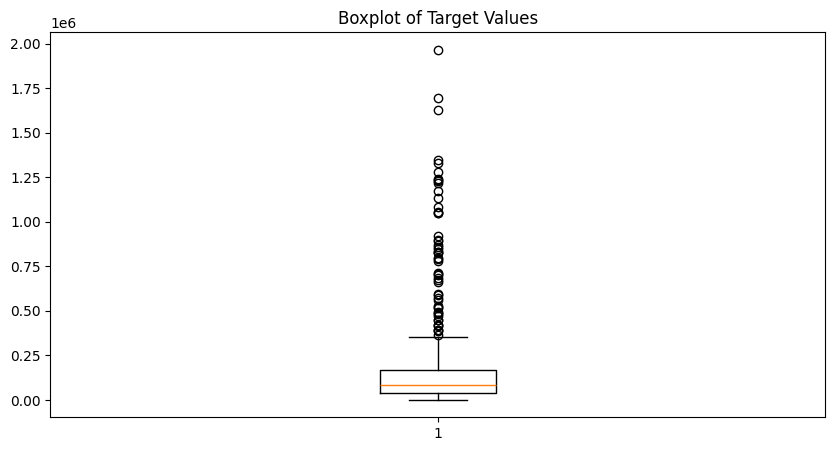

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.boxplot(weekly_budget_ts_df["target"])
plt.title("Boxplot of Target Values")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# 각 item_id(카테고리)별 통계값 계산
stats_df = weekly_budget_ts_df.groupby("item_id")["target"].agg(
    mean="mean",         # 평균
    std="std",           # 표준편차
    min="min",           # 최소값
    max="max",           # 최대값
    median="median",     # 중앙값
    variance="var",      # 분산
).reset_index()

print(stats_df)  # 기본 출력

   item_id           mean            std    min      max    median  \
0       교통   15152.813953   15955.391176   1092    51145    5973.0   
1    문화/여가   73009.545455   44955.968895   6140   188280   68175.0   
2    뷰티/미용  108594.000000   56263.546345  19140   261170  104010.0   
3       생활  118359.591837   53399.155500  14510   268570  108570.0   
4       쇼핑  177642.600000  125160.657260  10760   683200  150825.0   
5     술/유흥   74622.200000   42483.996665  13670   185330   73670.0   
6       식비   52695.000000   32383.255052   7530   118640   44985.0   
7    여행/숙박  753575.777778  480485.241952  54710  1966460  708100.0   
8    온라인쇼핑  387565.333333  252818.645517   8240  1082470  334410.0   
9    의료/건강   75100.769231   36538.681435   8460   130800   72790.0   
10   카페/간식   41982.765957   21735.924951   3310    93610   41770.0   

        variance  
0   2.545745e+08  
1   2.021039e+09  
2   3.165587e+09  
3   2.851470e+09  
4   1.566519e+10  
5   1.804890e+09  
6   1.048675e+09  
7   2.3

In [ ]:
# # 원본 데이터의 평균과 표준편차 구하기
# new_target_mean = normalized_weekly_budget_ts_df["target"].mean()
# new_target_std = normalized_weekly_budget_ts_df["target"].std()
# print(f"평균: {new_target_mean}, 표준편차: {new_target_std}")

평균: 11.283568289949272, 표준편차: 1.321818270270209


### 2️⃣ Chronos-Bolt 모델을 활용하여 2024년 전체 학습 후 2025년 예측

In [ ]:
# 모델 학습
predictor = TimeSeriesPredictor(prediction_length=4, freq="W")  # 'W'는 주 단위
predictor.fit(weekly_budget_ts_df)

print("🎯 모델 학습 완료! 이제 예측을 수행할 수 있습니다.")

Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training...
AutoGluon will save models to '/content/AutogluonModels/ag-20250204_154126'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       9.46 GB / 12.67 GB (74.6%)
Disk Space Avail:   200.51 GB / 235.68 GB (85.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 4,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'W-SUN'.
Provid

🎯 모델 학습 완료! 이제 예측을 수행할 수 있습니다.


### 다른 모델과의 비교(1) - AutoETS

In [ ]:
# ✅ predictor 초기화 (여기서는 model 지정 X)
predictor = TimeSeriesPredictor(
    prediction_length=2,
    freq="W"
)

# ✅ model 선택은 fit() 단계에서!
predictor.fit(weekly_budget_ts_df, hyperparameters={"AutoETS": {}})

# 예측 수행
predictions = predictor.predict(weekly_budget_ts_df)
print(predictions.head())

Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training...
AutoGluon will save models to '/content/AutogluonModels/ag-20250205_153101'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       11.09 GB / 12.67 GB (87.5%)
Disk Space Avail:   78.69 GB / 112.64 GB (69.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameters': {'AutoETS': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'W-SUN'.


                             mean           0.1           0.2           0.3  \
item_id timestamp                                                             
교통      2025-01-05    2517.070994   -312.883334    658.581865   1359.076622   
        2025-01-12    1330.327611   -165.952648    347.689635    718.061858   
문화/여가   2025-01-05   71185.805504  13405.909852  33240.561347  47542.740551   
        2025-01-12   71185.805504  13405.909563  33240.561157  47542.740433   
뷰티/미용   2025-01-05  134187.011496  50475.593954  79212.004333  99932.977980   

                              0.4            0.5            0.6  \
item_id timestamp                                                 
교통      2025-01-05    1957.623563    2517.070994    3076.518425   
        2025-01-12    1034.531266    1330.327611    1626.123956   
문화/여가   2025-01-05   59763.425339   71185.805504   82608.185669   
        2025-01-12   59763.425282   71185.805504   82608.185726   
뷰티/미용   2025-01-05  117638.285948  134187.01

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import IPython.display as display

# ✅ 1️⃣ 원래 데이터의 통계값 계산 (각 카테고리별 수요량)
stats_df = weekly_budget_ts_df.groupby("item_id")["target"].agg(
    mean="mean",         # 평균
    std="std",           # 표준편차
    min="min",           # 최소값
    max="max",           # 최대값
    median="median",     # 중앙값
    variance="var",      # 분산
).reset_index()

# ✅ 2️⃣ 예측 데이터에서 'mean' 컬럼만 선택하여 평균값 계산
predictions_mean = predictions[["mean"]].reset_index()  # index 복원

# ✅ 3️⃣ 예측값을 item_id별로 집계 (카테고리별 평균 예측값)
predictions_summary = predictions_mean.groupby("item_id")["mean"].mean().reset_index()
predictions_summary.rename(columns={"mean": "predicted_mean"}, inplace=True)  # 컬럼명 변경

# ✅ 4️⃣ 원래 값(`stats_df`)과 예측 값(`predictions_summary`)을 병합
comparison_df = pd.merge(stats_df, predictions_summary, on="item_id", how="left")

# ✅ 5️⃣ 비교 결과 출력
display.display(comparison_df)

,item_id,mean,std,min,max,median,variance,predicted_mean
0,교통,15152.813953,15955.391176,1092,51145,5973.0,2.545745e+08,1923.699303
1,문화/여가,73009.545455,44955.968895,6140,188280,68175.0,2.021039e+09,71185.805504
2,뷰티/미용,108594.000000,56263.546345,19140,261170,104010.0,3.165587e+09,134660.934652
3,생활,118359.591837,53399.155500,14510,268570,108570.0,2.851470e+09,116922.085274
4,쇼핑,177642.600000,125160.657260,10760,683200,150825.0,1.566519e+10,173289.274979
5,술/유흥,74622.200000,42483.996665,13670,185330,73670.0,1.804890e+09,74523.667069
6,식비,52695.000000,32383.255052,7530,118640,44985.0,1.048675e+09,51812.313033
7,여행/숙박,753575.777778,480485.241952,54710,1966460,708100.0,2.308661e+11,787986.817565
8,온라인쇼핑,387565.333333,252818.645517,8240,1082470,334410.0,6.391727e+10,375507.623663
9,의료/건강,75100.769231,36538.681435,8460,130800,72790.0,1.335075e+09,68374.661705


### 다른 모델과의 비교(2) - RecursiveTabular

In [ ]:
# ✅ predictor 초기화 (여기서는 model 지정 X)
predictor = TimeSeriesPredictor(
    prediction_length=2,
    freq="W"
)

# ✅ model 선택은 fit() 단계에서!
predictor.fit(weekly_budget_ts_df, hyperparameters={"RecursiveTabular": {}})

# 예측 수행
predictions = predictor.predict(weekly_budget_ts_df)
print(predictions.head())

Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training...
AutoGluon will save models to '/content/AutogluonModels/ag-20250205_153121'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       10.81 GB / 12.67 GB (85.3%)
Disk Space Avail:   78.67 GB / 112.64 GB (69.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameters': {'RecursiveTabular': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 

                             mean           0.1           0.2           0.3  \
item_id timestamp                                                             
교통      2025-01-05   12762.854428  -1182.742963   3604.494207   7056.429015   
        2025-01-12    8481.931645 -11240.121321  -4469.945589    411.827433   
문화/여가   2025-01-05   94820.978900  73357.822378  80725.683202  86038.429226   
        2025-01-12   97689.966421  67336.479376  77756.208079  85269.565559   
뷰티/미용   2025-01-05  112367.606801  81583.565923  92151.094914  99771.026801   

                              0.4            0.5            0.6  \
item_id timestamp                                                 
교통      2025-01-05   10005.980030   12762.854428   15519.728826   
        2025-01-12    4583.122482    8481.931645   12380.740809   
문화/여가   2025-01-05   90577.974814   94820.978900   99063.982986   
        2025-01-12   91689.452497   97689.966421  103690.480345   
뷰티/미용   2025-01-05  106281.977639  112367.60

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import IPython.display as display

# ✅ 1️⃣ 원래 데이터의 통계값 계산 (각 카테고리별 수요량)
stats_df = weekly_budget_ts_df.groupby("item_id")["target"].agg(
    mean="mean",         # 평균
    std="std",           # 표준편차
    min="min",           # 최소값
    max="max",           # 최대값
    median="median",     # 중앙값
    variance="var",      # 분산
).reset_index()

# ✅ 2️⃣ 예측 데이터에서 'mean' 컬럼만 선택하여 평균값 계산
predictions_mean = predictions[["mean"]].reset_index()  # index 복원

# ✅ 3️⃣ 예측값을 item_id별로 집계 (카테고리별 평균 예측값)
predictions_summary = predictions_mean.groupby("item_id")["mean"].mean().reset_index()
predictions_summary.rename(columns={"mean": "predicted_mean"}, inplace=True)  # 컬럼명 변경

# ✅ 4️⃣ 원래 값(`stats_df`)과 예측 값(`predictions_summary`)을 병합
comparison_df = pd.merge(stats_df, predictions_summary, on="item_id", how="left")

# ✅ 5️⃣ 비교 결과 출력
display.display(comparison_df)

,item_id,mean,std,min,max,median,variance,predicted_mean
0,교통,15152.813953,15955.391176,1092,51145,5973.0,2.545745e+08,1.062239e+04
1,문화/여가,73009.545455,44955.968895,6140,188280,68175.0,2.021039e+09,9.625547e+04
2,뷰티/미용,108594.000000,56263.546345,19140,261170,104010.0,3.165587e+09,1.206531e+05
3,생활,118359.591837,53399.155500,14510,268570,108570.0,2.851470e+09,1.648964e+05
4,쇼핑,177642.600000,125160.657260,10760,683200,150825.0,1.566519e+10,7.452815e+04
5,술/유흥,74622.200000,42483.996665,13670,185330,73670.0,1.804890e+09,8.346400e+04
6,식비,52695.000000,32383.255052,7530,118640,44985.0,1.048675e+09,7.258866e+04
7,여행/숙박,753575.777778,480485.241952,54710,1966460,708100.0,2.308661e+11,1.061922e+06
8,온라인쇼핑,387565.333333,252818.645517,8240,1082470,334410.0,6.391727e+10,5.705019e+05
9,의료/건강,75100.769231,36538.681435,8460,130800,72790.0,1.335075e+09,5.355933e+04


In [ ]:
import numpy as np

# ✅ 가장 최근의 timestamp 가져오기
last_timestamp = weekly_budget_ts_df.index.get_level_values("timestamp").max()

# ✅ 미래 4주간의 timestamp 생성
future_dates = pd.date_range(
    start=last_timestamp + pd.Timedelta(weeks=1),  # 마지막 timestamp 이후 1주일부터 시작
    periods=4,  # 4주 예측
    freq="W"  # 주 단위 ('W')
)

# ✅ MultiIndex에서 'item_id' 정보 가져오기
unique_categories = weekly_budget_ts_df.index.get_level_values("item_id").unique()

# ✅ 미래 예측을 위한 데이터 생성
future_df = pd.DataFrame({
    "timestamp": future_dates.repeat(len(unique_categories)),  # 4주간 반복
    "item_id": list(unique_categories) * len(future_dates)  # 각 item_id(카테고리)에 대해 반복
})

# target 값을 NaN으로 설정 (모델이 예측할 부분)
future_df["target"] = np.nan  # NaN을 넣어서 dtype을 float으로 설정

# TimeSeriesDataFrame으로 변환
# future_ts_df = TimeSeriesDataFrame(future_df)
future_ts_df = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="item_id"
)

# 예측 수행
predictions = predictor.predict(future_ts_df)

# 예측 결과 확인
print(predictions)


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                        mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
교통      2025-02-09  2.212026  1.854194  1.997556  2.081518  2.155251   
        2025-02-16  2.210276  1.772094  1.943178  2.046960  2.137905   
        2025-02-23  2.212212  1.714496  1.906332  2.024554  2.127956   
        2025-03-02  2.213125  1.663701  1.873420  2.004581  2.119181   
문화/여가   2025-02-09  2.212026  1.933721  2.049784  2.114060  2.170972   
        2025-02-16  2.210276  1.884563  2.017039  2.092982  2.160139   
        2025-02-23  2.212212  1.852242  1.996793  2.080919  2.155186   
        2025-03-02  2.213125  1.822757  1.977875  2.069665  2.150625   
뷰티/미용   2025-02-09  2.212026  1.912207  2.035655  2.105256  2.166719   
        2025-02-16  2.210276  1.854138  1.997058  2.080532  2.154124   
        2025-02-23  2.212212  1.814979  1.972322  2.065671  2.147820   
        2025-03-02  2.213125  1.779729  1.949618  2.052059  2.14

In [ ]:
# 예측 결과를 Pandas DataFrame으로 변환
predictions_df = pd.DataFrame(predictions).reset_index()

# 예측 결과를 CSV 파일로 저장
predictions_df.to_csv("predicted_weekly_budget.csv", index=False)

print("✅ 예측 데이터 저장 완료! ('predicted_weekly_budget.csv')")


✅ 예측 데이터 저장 완료! ('predicted_weekly_budget.csv')


### 3️⃣ 예산 초과 가능성이 높은 카테고리 추출 및 미션 생성 -> 아직 X

In [ ]:
# 카테고리별 주간 예산 설정 (예제)
budgets = {
    "교통": 50000, "쇼핑": 150000, "뷰티/미용": 30000,
    "여행/숙박": 400000, "생활": 50000
}

# 예측 결과 기반 미션 생성
missions = []
category_forecasts = {}  # 카테고리별 예측 소비 금액 저장

unique_categories = predictions.index.get_level_values(0).unique()  # item_id(카테고리) 추출

for category in unique_categories:
    total_forecast = predictions.loc[category, "mean"].sum()  # 카테고리별 예측 소비 금액 합계
    category_forecasts[category] = total_forecast  # 저장

    budget = budgets.get(category, 0)

    if total_forecast > budget * 0.8:  # 예산의 80% 이상 사용 예상되면 미션 생성
        if category == "교통":
            missions.append(f"🚦 이번 주 교통비 예산 초과 가능성이 있습니다! (예측 소비: {total_forecast:.2f}원) 대중교통 이용을 늘려보세요.")
        elif category == "쇼핑":
            missions.append(f"🛍 이번 주 쇼핑 지출이 많을 것으로 예상됩니다. (예측 소비: {total_forecast:.2f}원) 구매를 신중하게 결정해보세요!")
        elif category == "뷰티/미용":
            missions.append(f"💄 이번 주 미용비가 예산을 초과할 가능성이 있습니다. (예측 소비: {total_forecast:.2f}원) 미용 서비스를 조절해보세요.")
        elif category == "여행/숙박":
            missions.append(f"✈️ 이번 주 여행/숙박비가 높을 수 있습니다. (예측 소비: {total_forecast:.2f}원) 여행 계획을 다시 검토해보세요!")
        elif category == "생활":
            missions.append(f"🏠 이번 주 생활비가 예상보다 많이 나갈 수 있습니다. (예측 소비: {total_forecast:.2f}원) 지출을 점검해보세요.")

# ✅ 카테고리별 예측 소비 금액 합계 출력
print("📊 카테고리별 예측 소비 금액 합계:")
for category, amount in category_forecasts.items():
    print(f"🔹 {category}: {amount:.2f}원")

# ✅ 생성된 미션 출력
print("\n📢 생성된 미션:")
for mission in missions:
    print(mission)

나중에 추가할 것

In [ ]:
# 1) 다른 column

# predictor = TimeSeriesPredictor(
#     target="sales",
#     prediction_length=3,
#     known_covariates_names=["holiday", "promotion"]
# )

# 2) category별 특징 (ex. 고정비/변동비, ...)
# # ✅ static_features 설정 (각 category에 대한 추가적인 특성 제공)
# df.static_features = pd.DataFrame(
#     {"category_type": ["고정비", "변동비", "고정비", "변동비", "변동비"]},  # 예제 데이터
#     index=unique_categories  # static_features의 index는 반드시 item_id(= category)와 동일해야 함
# )

# 3) 정규화
# 돈이어서 금액이 크기 때문에 20000 -> 200 이러면 좋을듯
